In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/tpu-getting-started/sample_submission.csv
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/04-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/15-224x224-232.tfrec
/kaggle/input/tpu-getting-started/tfrecord

In [2]:
import math, re, os, random
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("TF version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TF version 2.14.0


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-11-13 02:21:36.085432: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:21:36.085535: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:21:36.085623: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:21:36.085708: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:21:36.085782: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:21:36.085995: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:21:36.086089: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [4]:
IMAGE_SIZE = [192, 192]
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
SEED = 752
SKIP_VALIDATION = False
TTA_NUM = 5

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition 
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']           

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/tpu-getting-started


In [6]:
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
         
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [7]:
def random_blockout(img, sl=0.1, sh=0.2, rl=0.4):
    p=random.random()
    if p>=0.25:
        w, h, c = IMAGE_SIZE[0], IMAGE_SIZE[1], 3
        origin_area = tf.cast(h*w, tf.float32)

        e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
        e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

        e_height_h = tf.minimum(e_size_h, h)
        e_width_h = tf.minimum(e_size_h, w)

        erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
        erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

        erase_area = tf.zeros(shape=[erase_height, erase_width, c])
        erase_area = tf.cast(erase_area, tf.uint8)

        pad_h = h - erase_height
        pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
        pad_bottom = pad_h - pad_top

        pad_w = w - erase_width
        pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
        pad_right = pad_w - pad_left
        erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
        erase_mask = tf.squeeze(erase_mask, axis=0)
        erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

        return tf.cast(erased_img, img.dtype)
    else:
        return tf.cast(img, img.dtype)

In [8]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs
def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.

    image = tf.image.random_flip_left_right(image, seed=SEED)
    image = random_blockout(image)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [9]:
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES

In [10]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Training data label examples: [102  55   4 ...  56 103  90]
Validation data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Validation data label examples: [85 41 47 ... 86 45  9]
Test data shapes:
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
(128, 192, 192, 3) (128,)
Test data IDs: ['1a96992d9' '12c738d87' '6ef2473d3' ... '246798d36' '35cb5e3c3' '8c8ffc7cf']


In [11]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

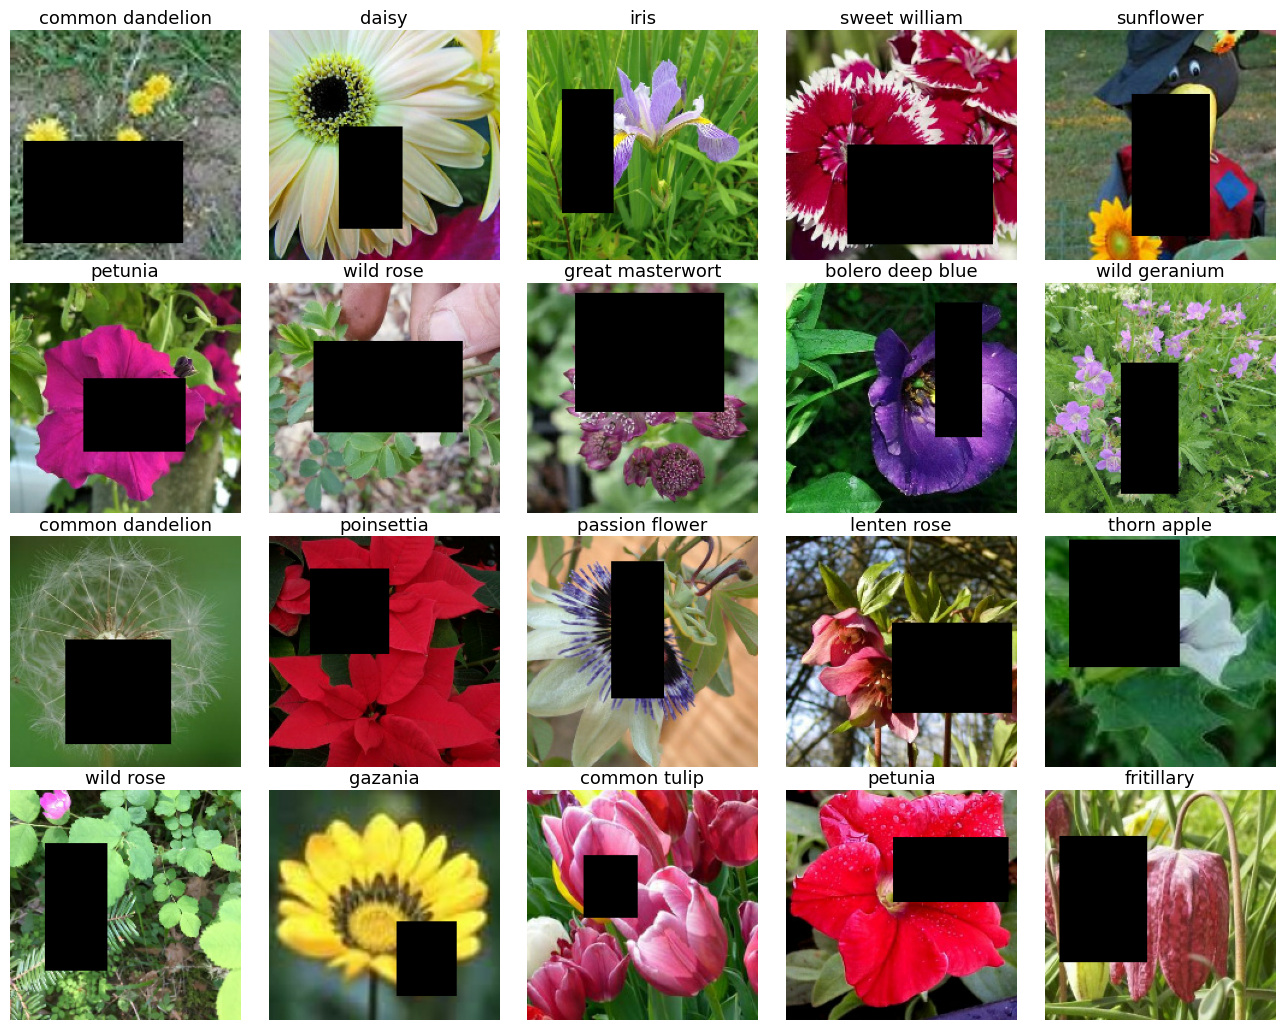

In [12]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))


In [13]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

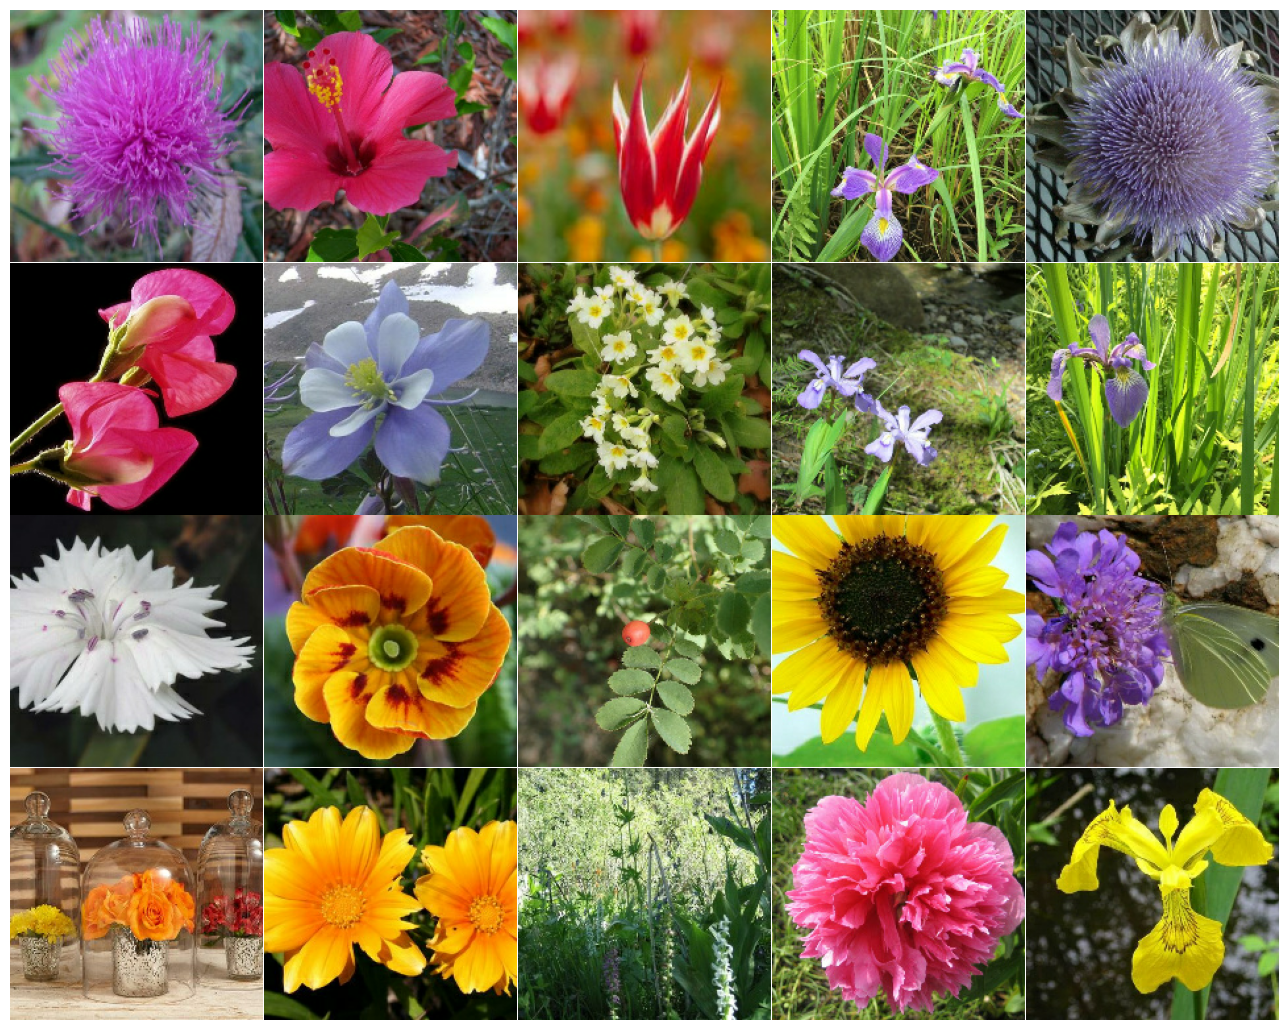

In [14]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

Learning rate schedule: 1e-05 to 0.0004 to 1.56e-05


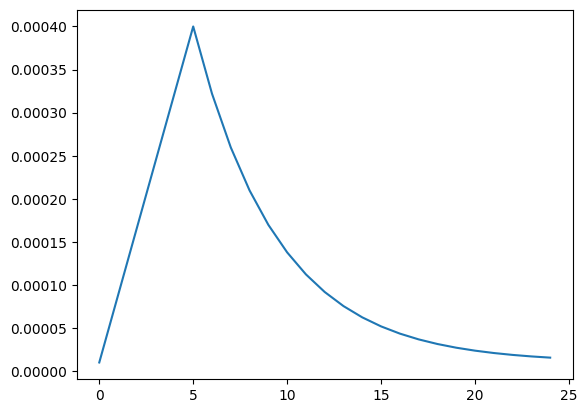

In [15]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [16]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [17]:
with strategy.scope():
    enet = efn.EfficientNetB7(input_shape=[*IMAGE_SIZE, 3], weights='noisy-student', include_top=False)
    enet.trainable = True

    model1 = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
            
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model1.summary()

2023-11-13 02:24:05.965452: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:05.965562: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


258068648/258068648 [==============================] - 1s 0us/step


2023-11-13 02:24:36.370996: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:36.371782: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:36.372550: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:36.373343: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:36.374114: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:36.374807: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:24:36.375690: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functiona  (None, 6, 6, 2560)        64097680  
 l)                                                              
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 104)               266344    
                                                                 
Total params: 64364024 (245.53 MB)
Trainable params: 64053304 (244.34 MB)
Non-trainable params: 310720 (1.19 MB)
_________________________________________________________________


In [18]:
if not SKIP_VALIDATION:
    history1 = model1.fit(get_training_dataset(),  
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        validation_data=get_validation_dataset(), 
                        callbacks = [lr_callback])
else:
    history1 = model1.fit(get_training_dataset(), 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS, 
                        callbacks = [lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10


2023-11-13 02:28:04.491892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-11-13 02:28:13.976097: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:28:13.976315: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:28:14.007105: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:28:14.007324: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:28:14.008290: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-13 02:28:14.008377: E ./tensorflow/compiler/xla/stream_executor/st

 1/99 [..............................] - ETA: 5:44:37 - loss: 4.6534 - sparse_categorical_accuracy: 0.0234

2023-11-13 02:30:14.388836: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


99/99 [==============================] - ETA: 0s - loss: 4.6499 - sparse_categorical_accuracy: 0.0140

2023-11-13 02:30:50.211084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 267s 571ms/step - loss: 4.6499 - sparse_categorical_accuracy: 0.0140 - val_loss: 4.6469 - val_sparse_categorical_accuracy: 0.0127 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
99/99 [==============================] - 32s 325ms/step - loss: 4.0744 - sparse_categorical_accuracy: 0.1604 - val_loss: 3.4385 - val_sparse_categorical_accuracy: 0.2619 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
99/99 [==============================] - 32s 322ms/step - loss: 2.6499 - sparse_categorical_accuracy: 0.3932 - val_loss: 1.8253 - val_sparse_categorical_accuracy: 0.5859 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
99/99 [==============================] - 32s 328ms/step - loss: 1.5090 - sparse_categorical_accuracy: 0.6191 - val_loss: 0.9316 - val_sparse_categorical_accuracy: 0.7791 - lr: 2.4400e-04

Epoch 5: Learning

In [20]:
with strategy.scope():
    
    xception = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], weights='imagenet', include_top=False)
    xception.trainable = True
    
    model2 = tf.keras.Sequential([
        xception,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    model2.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
    )
        
    model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 104)               213096    
                                                                 
Total params: 21074576 (80.39 MB)
Trainable params: 21020048 (80.19 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [21]:
if not SKIP_VALIDATION:
    history2 = model2.fit(get_training_dataset(), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        validation_data=get_validation_dataset(), 
                        callbacks = [lr_callback])
else:
    history2 = model2.fit(get_training_dataset(), 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS, 
                        callbacks = [lr_callback])



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10


2023-11-13 02:36:43.119783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 69s 196ms/step - loss: 4.5627 - sparse_categorical_accuracy: 0.0344 - val_loss: 4.3243 - val_sparse_categorical_accuracy: 0.0838 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
99/99 [==============================] - 11s 110ms/step - loss: 3.2042 - sparse_categorical_accuracy: 0.3153 - val_loss: 1.9615 - val_sparse_categorical_accuracy: 0.5321 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
99/99 [==============================] - 11s 111ms/step - loss: 1.6475 - sparse_categorical_accuracy: 0.6133 - val_loss: 0.9521 - val_sparse_categorical_accuracy: 0.7608 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
99/99 [==============================] - 11s 111ms/step - loss: 0.9630 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.6747 - val_sparse_categorical_accuracy: 0.8341 - lr: 2.4400e-04

Epoch 5: LearningR

In [22]:
if not SKIP_VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m1 = model1.predict(images_ds)
    m2 = model2.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha*m1+(1-alpha)*m2
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    best_alpha = np.argmax(scores)/100
else:
    best_alpha = 0.51  # change to value calculated with SKIP_VALIDATION=False
    
print('Best alpha: ' + str(best_alpha))

2023-11-13 02:39:22.984207: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


29/29 [==============================] - 9s 33ms/step
Best alpha: 0.56


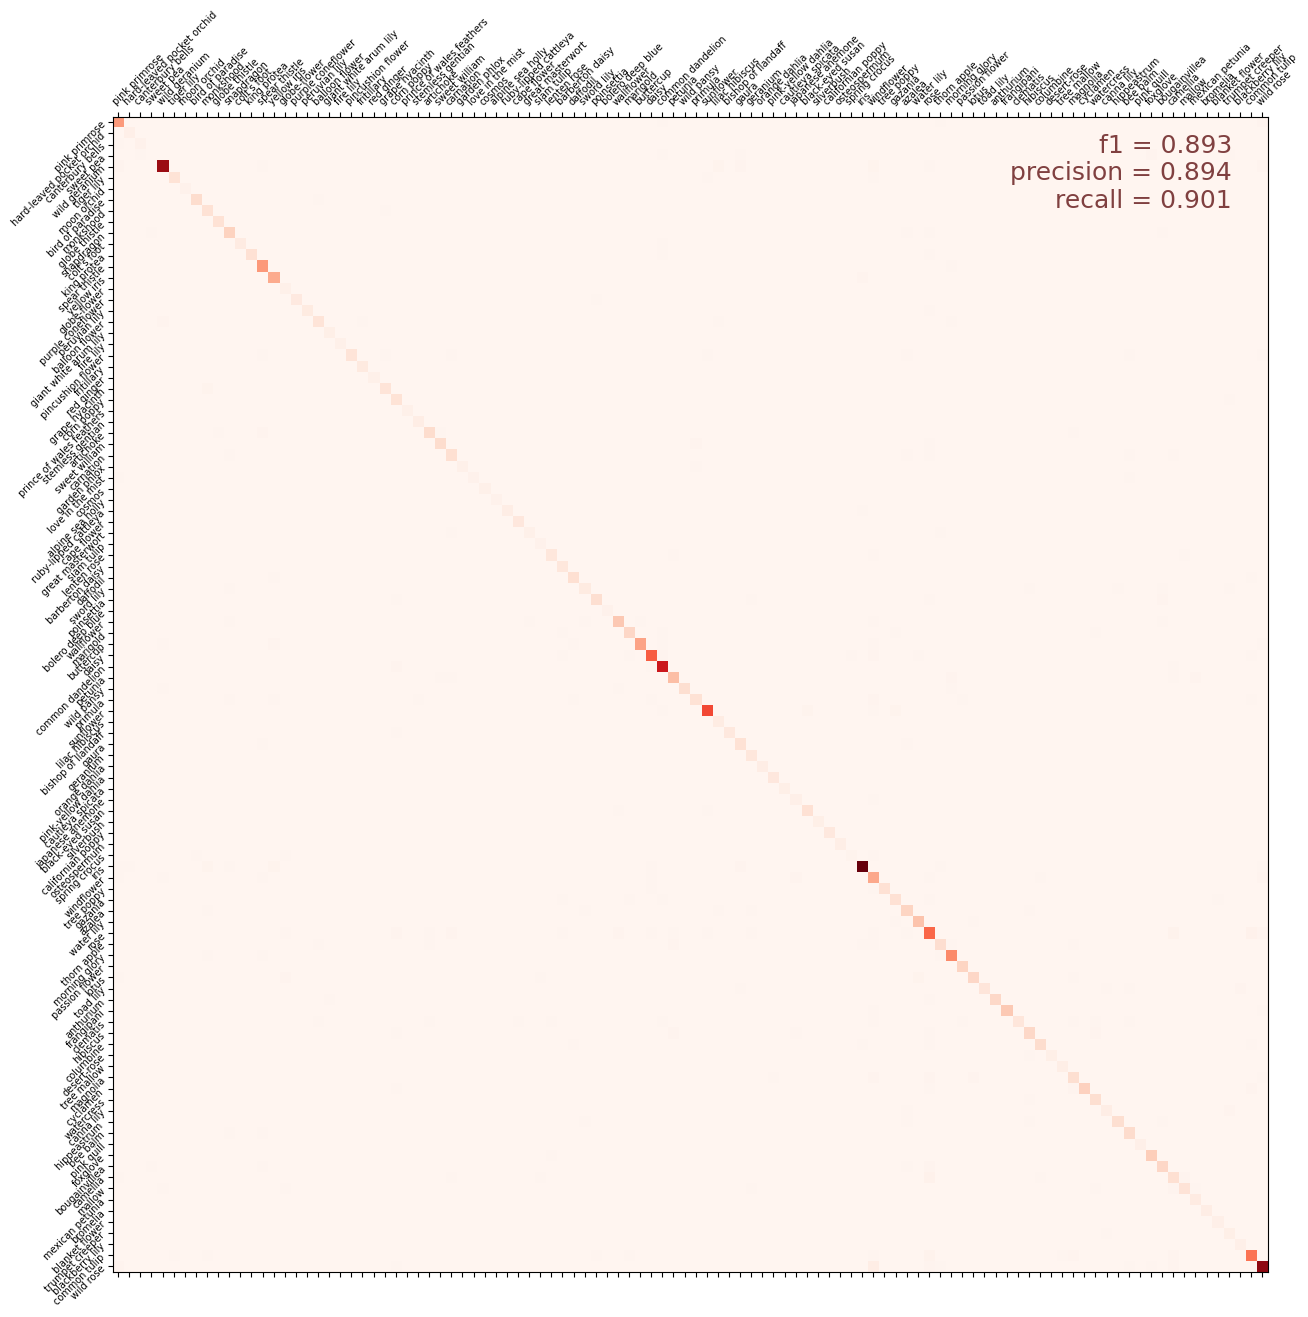

f1 score: 0.893, precision: 0.894, recall: 0.901


In [24]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))


In [25]:
def predict_tta(model, n_iter):
    probs  = []
    for i in range(n_iter):
        test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
        test_images_ds = test_ds.map(lambda image, idnum: image)
        probs.append(model.predict(test_images_ds,verbose=0))
        
    return probs

In [26]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Calculating predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probs1 = np.mean(predict_tta(model1, TTA_NUM), axis=0)
probs2 = np.mean(predict_tta(model2, TTA_NUM), axis=0)
probabilities = best_alpha*probs1 + (1-best_alpha)*probs2
predictions = np.argmax(probabilities, axis=-1)

print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Calculating predictions...
Generating submission file...


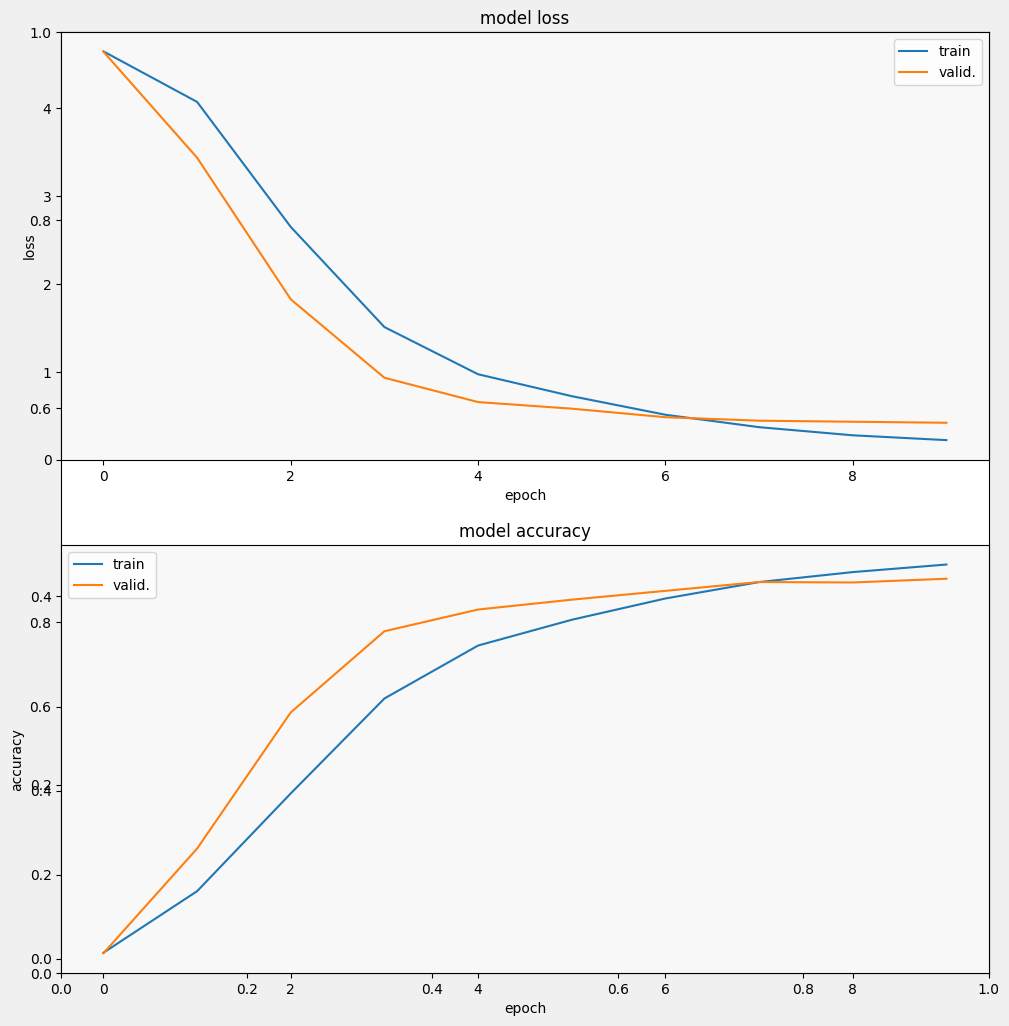

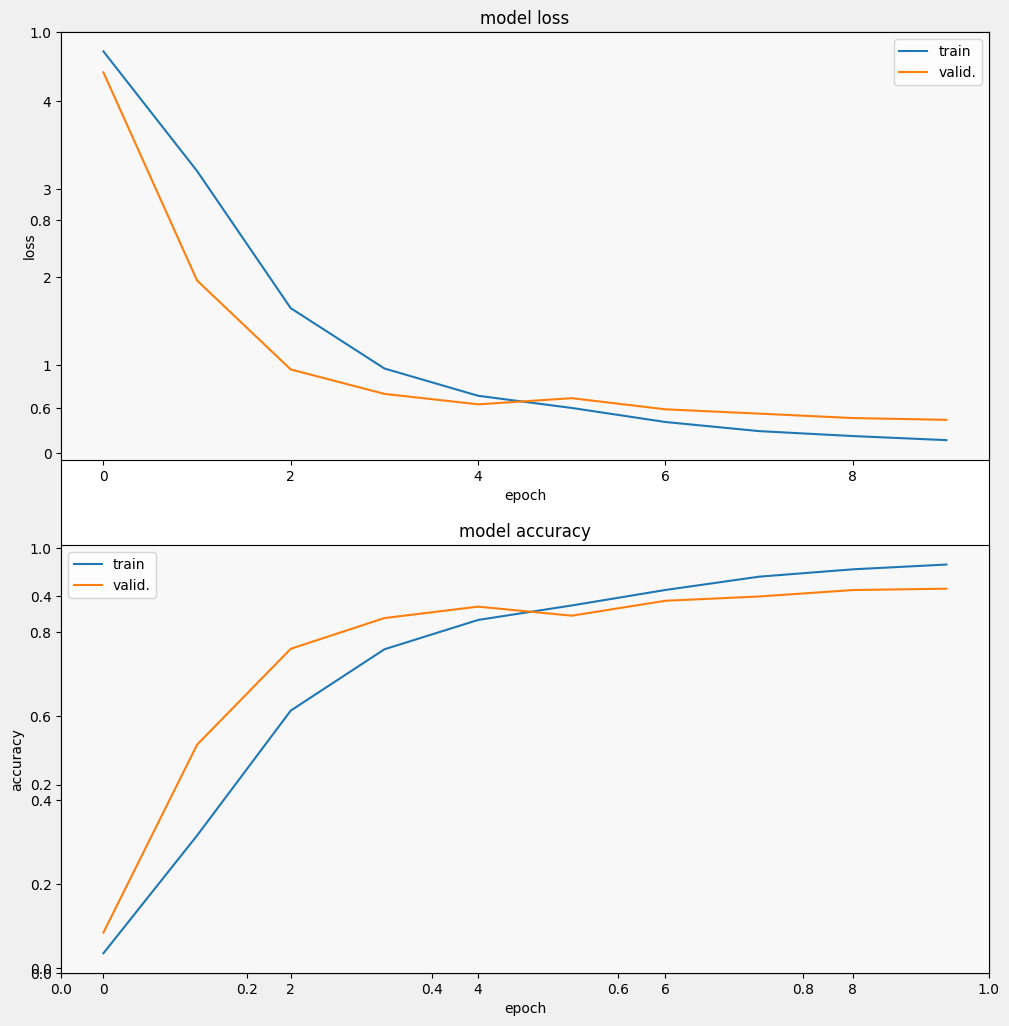

In [27]:
display_training_curves(
    history1.history['loss'],
    history1.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history1.history['sparse_categorical_accuracy'],
    history1.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)
display_training_curves(
    history2.history['loss'],
    history2.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history2.history['sparse_categorical_accuracy'],
    history2.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functiona  (None, 6, 6, 2560)        64097680  
 l)                                                              
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 32)          737312    
                                                                 
 global_average_pooling2d_9  (None, 32)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 200)               6600      
                                                                 
Total params: 64841592 (247.35 MB)
Trainable params: 64530872 (246.17 MB)
Non-trainable params: 310720 (1.19 MB)
_________________________________________________________________

Epoch 

2023-11-13 04:32:48.816116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 11.4227 - sparse_categorical_accuracy: 0.0088

2023-11-13 04:35:36.179063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 267s 573ms/step - loss: 11.4227 - sparse_categorical_accuracy: 0.0088 - val_loss: 9.7431 - val_sparse_categorical_accuracy: 0.0137 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
99/99 [==============================] - 33s 336ms/step - loss: 10.1604 - sparse_categorical_accuracy: 0.0128 - val_loss: 9.1074 - val_sparse_categorical_accuracy: 0.0046 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
99/99 [==============================] - 33s 336ms/step - loss: 8.9310 - sparse_categorical_accuracy: 0.0088 - val_loss: 8.1915 - val_sparse_categorical_accuracy: 0.0108 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
99/99 [==============================] - 33s 332ms/step - loss: 8.7548 - sparse_categorical_accuracy: 0.0202 - val_loss: 9.9162 - val_sparse_categorical_accuracy: 0.0070 - lr: 2.4400e-04

Epoch 5: Learni

2023-11-13 04:42:43.560949: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 9.1467 - sparse_categorical_accuracy: 0.0028

2023-11-13 04:45:28.923228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 273s 579ms/step - loss: 9.1467 - sparse_categorical_accuracy: 0.0028 - val_loss: 8.2919 - val_sparse_categorical_accuracy: 0.0027 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
99/99 [==============================] - 33s 337ms/step - loss: 8.3634 - sparse_categorical_accuracy: 0.0150 - val_loss: 8.1126 - val_sparse_categorical_accuracy: 0.0178 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
99/99 [==============================] - 33s 338ms/step - loss: 7.8782 - sparse_categorical_accuracy: 0.0180 - val_loss: 7.5653 - val_sparse_categorical_accuracy: 0.0178 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
99/99 [==============================] - 34s 343ms/step - loss: 7.1063 - sparse_categorical_accuracy: 0.0152 - val_loss: 6.7822 - val_sparse_categorical_accuracy: 0.0116 - lr: 2.4400e-04

Epoch 5: Learning

2023-11-13 04:52:24.249923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - ETA: 0s - loss: 8.4621 - sparse_categorical_accuracy: 0.0088

2023-11-13 04:55:06.665195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 266s 571ms/step - loss: 8.4621 - sparse_categorical_accuracy: 0.0088 - val_loss: 7.1549 - val_sparse_categorical_accuracy: 0.0552 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
99/99 [==============================] - 33s 335ms/step - loss: 7.7753 - sparse_categorical_accuracy: 0.0109 - val_loss: 7.1384 - val_sparse_categorical_accuracy: 0.0100 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
99/99 [==============================] - 33s 330ms/step - loss: 7.8310 - sparse_categorical_accuracy: 0.0236 - val_loss: 8.7476 - val_sparse_categorical_accuracy: 0.0442 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
99/99 [==============================] - 33s 332ms/step - loss: 8.0118 - sparse_categorical_accuracy: 0.0440 - val_loss: 7.8706 - val_sparse_categorical_accuracy: 0.0442 - lr: 2.4400e-04

Epoch 5: Learning

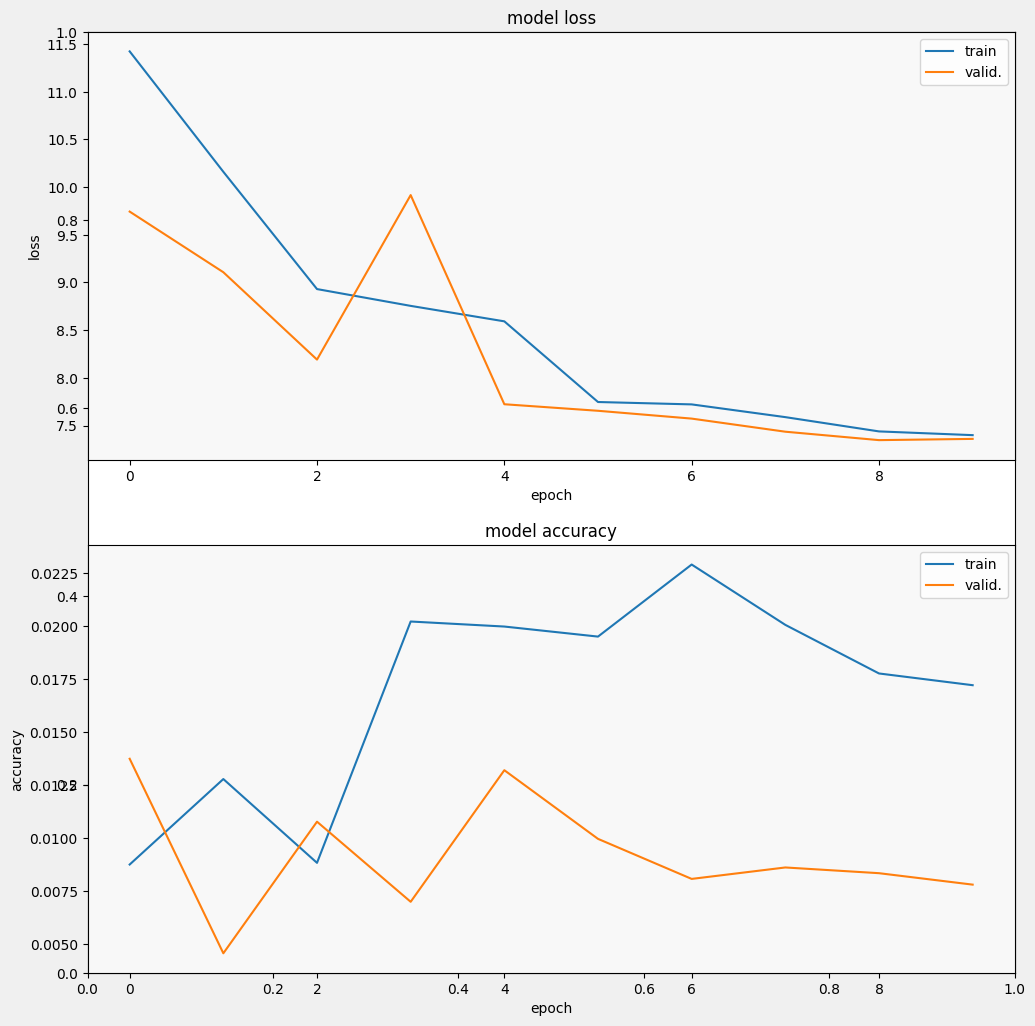

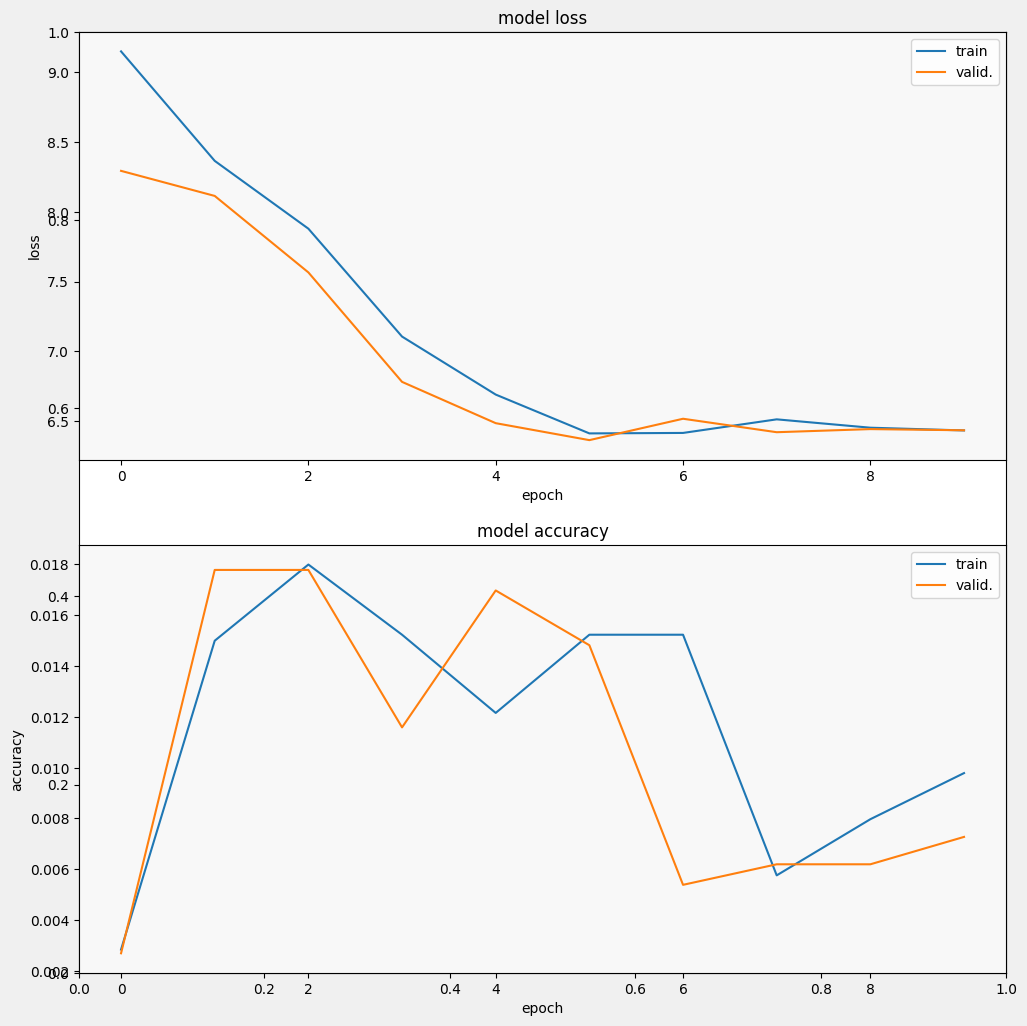

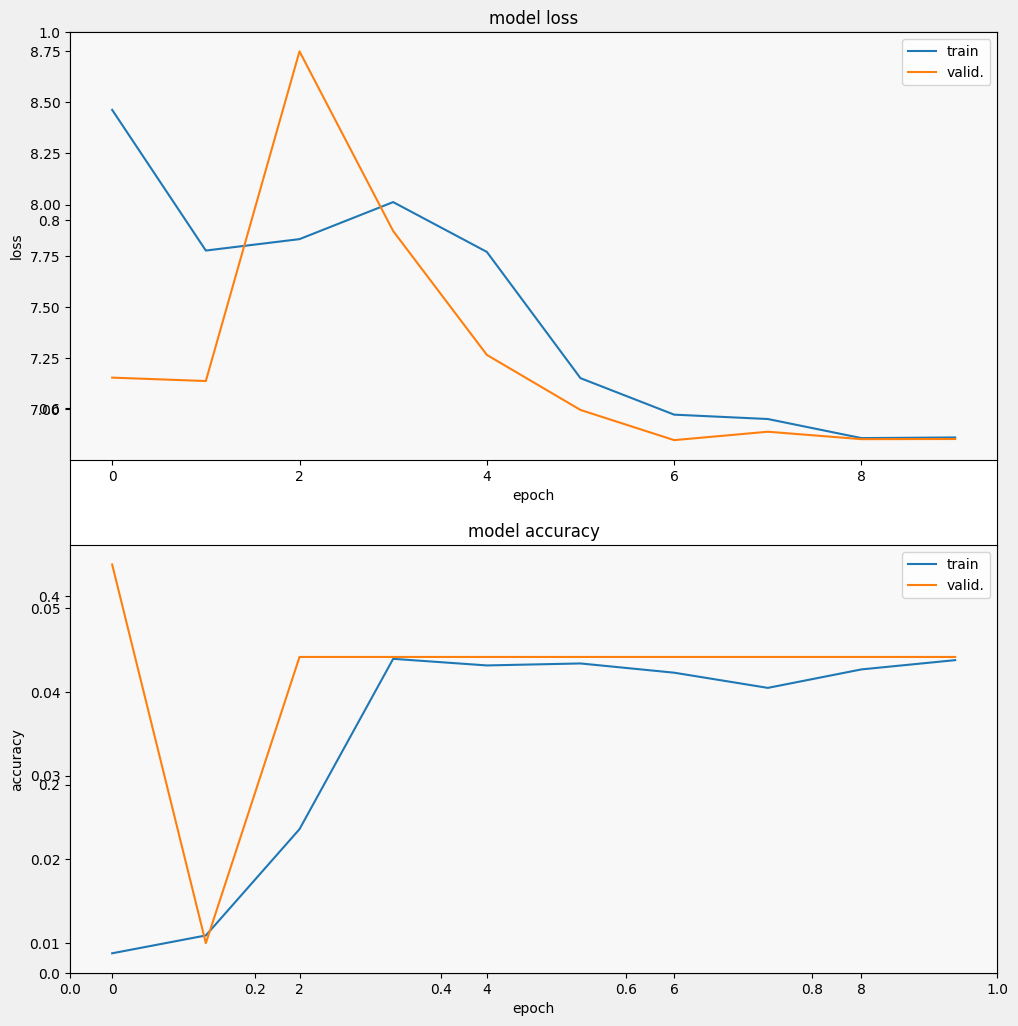

In [62]:
import time
with strategy.scope():
    enet = efn.EfficientNetB7(input_shape=[*IMAGE_SIZE, 3], weights='noisy-student', include_top=False)
    enet.trainable = True
    history=[]
    training_times=[]
    val_accuracies = []
    kernel_sizes = [(3, 3), (5, 5), (6, 6)]  
    num_filters = [32, 64, 128]
    num_neurons = [200,300,400]  
    for i in range(len(num_filters)):
        model4 = tf.keras.Sequential([
            enet,
            tf.keras.layers.Conv2D(num_filters[i], kernel_sizes[i], activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(num_neurons[i], activation='relu')
        ])
        model4.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])
        
        model4.summary()
        # Record start time
        start_time = time.time()

        history4 = model4.fit(get_training_dataset(), 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS, 
                        validation_data=get_validation_dataset(), 
                        callbacks = [lr_callback])
         # Record end time
        end_time = time.time()
        
        history.append(history4)
        
        training_time = end_time - start_time
        training_times.append(training_time)
        
        val_accuracy = history4.history['val_sparse_categorical_accuracy']
        val_accuracies.append(val_accuracy[-1])
        
        display_training_curves(
            history4.history['loss'],
            history4.history['val_loss'],
            'loss',
            211,
        )
        display_training_curves(
            history4.history['sparse_categorical_accuracy'],
            history4.history['val_sparse_categorical_accuracy'],
            'accuracy',
            212,
        )

In [63]:
training_times

[566.8331105709076, 578.1055860519409, 562.3266072273254]

In [64]:
val_accuracies

[0.0078125, 0.007273707073181868, 0.044181033968925476]

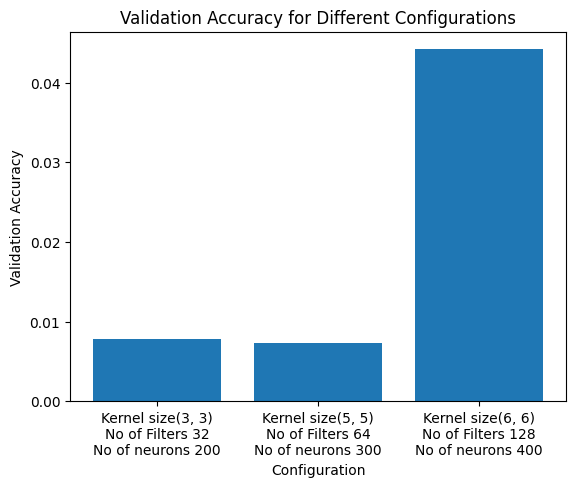

In [65]:
plt.bar(range(len(val_accuracies)), val_accuracies, tick_label=[f'Kernel size{kernel_sizes[i]}\nNo of Filters {num_filters[i]}\nNo of neurons {num_neurons[i]}' for i in range(len(kernel_sizes))])
plt.xlabel('Configuration')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Configurations')
plt.show()

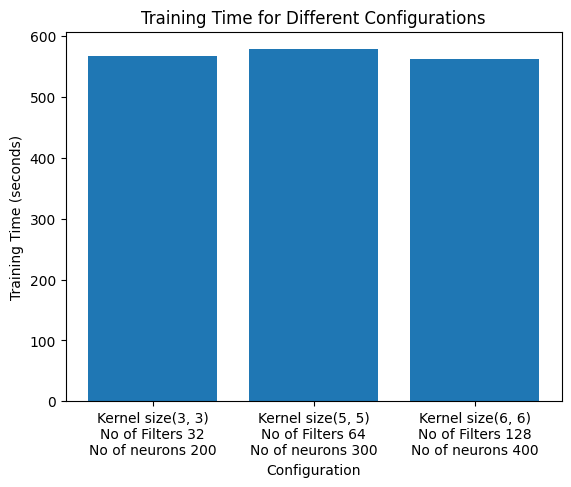

In [66]:
plt.bar(range(len(training_times)), training_times, tick_label=[f'Kernel size{kernel_sizes[i]}\nNo of Filters {num_filters[i]}\nNo of neurons {num_neurons[i]}' for i in range(len(kernel_sizes))])
plt.xlabel('Configuration')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time for Different Configurations')
plt.show()

In [67]:
with strategy.scope():
    
    ResNet50 = tf.keras.applications.ResNet50(input_shape=[*IMAGE_SIZE, 3], weights='imagenet', include_top=False)
    ResNet50.trainable = True
    
    model5 = tf.keras.Sequential([
        ResNet50,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    
    model5.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
    )
        
    model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_12 (Dense)            (None, 104)               213096    
                                                                 
Total params: 23800808 (90.79 MB)
Trainable params: 23747688 (90.59 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [68]:
if not SKIP_VALIDATION:
    history5 = model5.fit(get_training_dataset(), 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        validation_data=get_validation_dataset(), 
                        callbacks = [lr_callback])
else:
    history5 = model5.fit(get_training_dataset(), 
                        steps_per_epoch=STEPS_PER_EPOCH,
                        epochs=EPOCHS, 
                        callbacks = [lr_callback])


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10


2023-11-13 05:07:30.103582: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


99/99 [==============================] - 76s 209ms/step - loss: 4.4365 - sparse_categorical_accuracy: 0.0787 - val_loss: 5.0870 - val_sparse_categorical_accuracy: 0.0385 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
99/99 [==============================] - 12s 122ms/step - loss: 2.2572 - sparse_categorical_accuracy: 0.4791 - val_loss: 5.6735 - val_sparse_categorical_accuracy: 0.0304 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
99/99 [==============================] - 12s 126ms/step - loss: 1.1169 - sparse_categorical_accuracy: 0.7099 - val_loss: 8.3060 - val_sparse_categorical_accuracy: 0.0447 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
99/99 [==============================] - 13s 127ms/step - loss: 0.7949 - sparse_categorical_accuracy: 0.7865 - val_loss: 5.1442 - val_sparse_categorical_accuracy: 0.0652 - lr: 2.4400e-04

Epoch 5: LearningR

In [69]:
if not SKIP_VALIDATION:
    cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
    images_ds = cmdataset.map(lambda image, label: image)
    labels_ds = cmdataset.map(lambda image, label: label).unbatch()
    cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
    m1 = model1.predict(images_ds)
    m2 = model2.predict(images_ds)
    m3 = model5.predict(images_ds)
    scores = []
    for alpha in np.linspace(0,1,100):
        cm_probabilities = alpha * m1 + (1 - alpha * 2) * m2 + alpha * m3
        cm_predictions = np.argmax(cm_probabilities, axis=-1)
        scores.append(f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro'))

    best_alpha = np.argmax(scores)/100
else:
    best_alpha = 0.51  # change to value calculated with SKIP_VALIDATION=False
    
print('Best alpha: ' + str(best_alpha))

29/29 [==============================] - 2s 34ms/step


2023-11-13 05:10:24.000691: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


29/29 [==============================] - 9s 37ms/step
Best alpha: 0.3


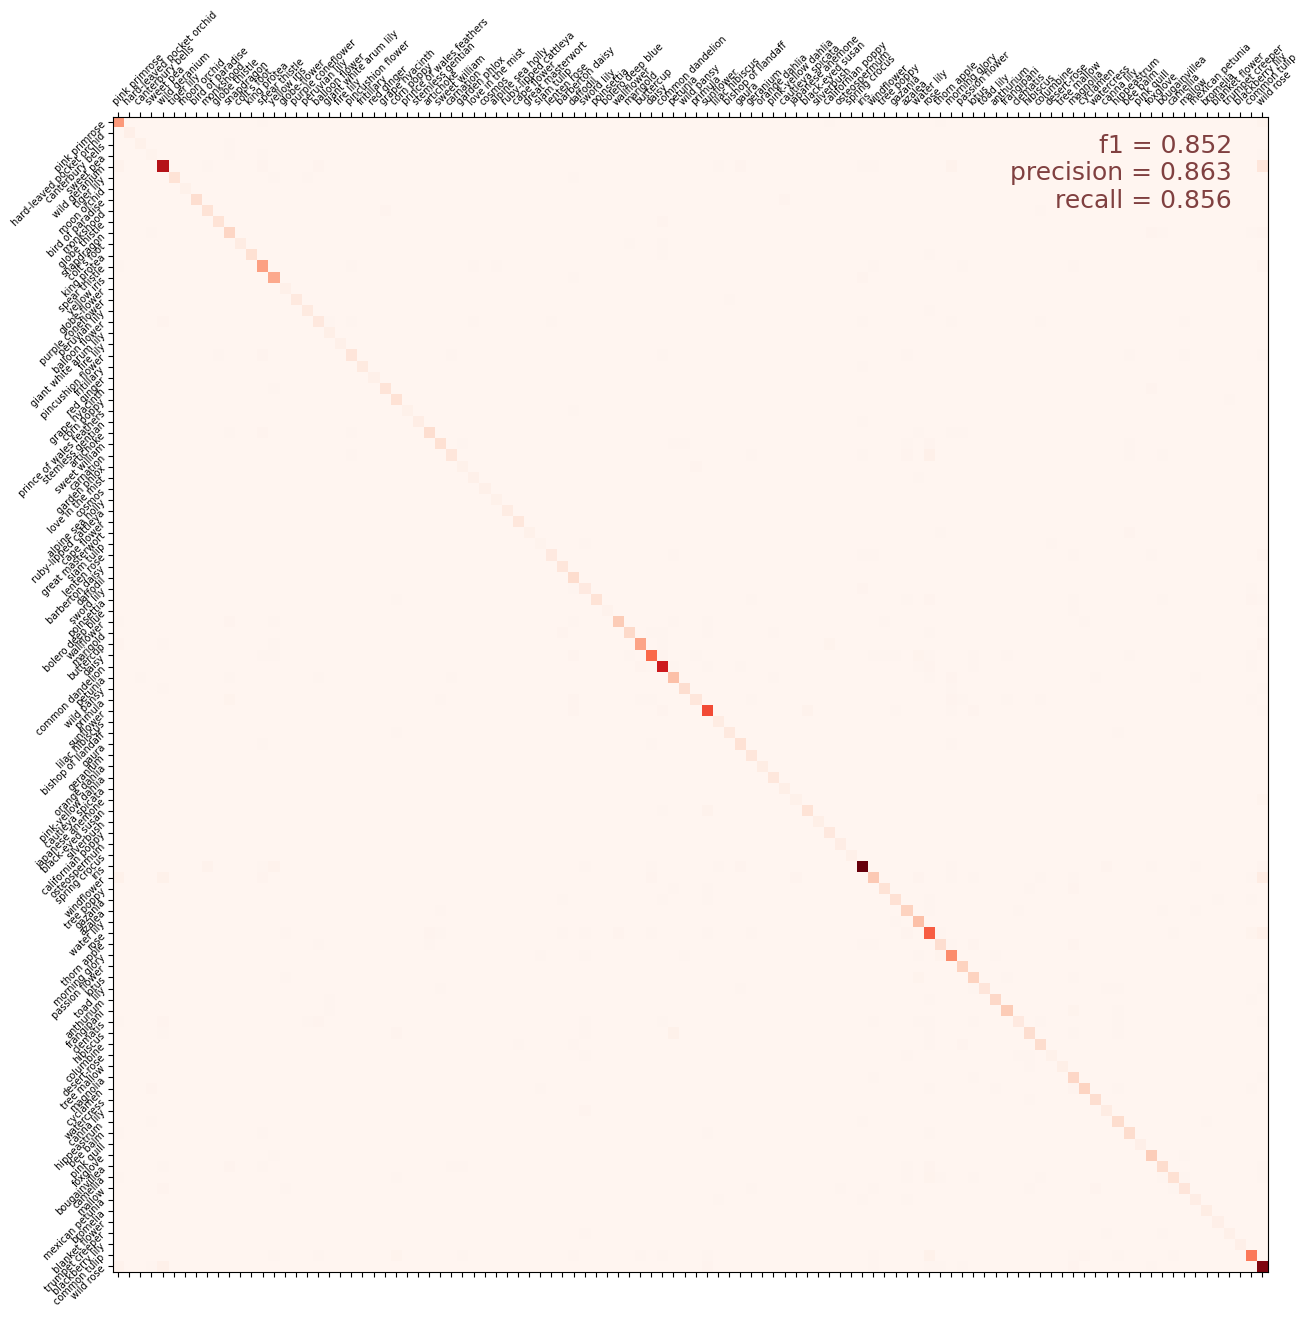

f1 score: 0.852, precision: 0.863, recall: 0.856


In [70]:
if not SKIP_VALIDATION:
    cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
    score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
    #cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
